<a href="https://colab.research.google.com/github/Psutar44/petsc4py/blob/master/S2_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Run me first: 

Run the following cell to initialize the Earth Engine API. The output will contain instructions on how to grant this notebook access to Earth Engine using your account.

In [ ]:
import ee
import datetime
import math
import os
import sys
sys.path.append(os.path.join(os.path.dirname(os.getcwd()),'bin'))

ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=sZ5PVGR_DZbkhKuHY0VLMIF2crtUkosF4ofN_f8oWrg&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AY0e-g7ZgJ4pAKUJbgWHEJLexBs9KeWCQahutXmEyqzCJhjz9ZJsGDU3yuc

Successfully saved authorization token.


In [ ]:
"""
 * Function to mask clouds using the Sentinel-2 QA band
 * @param {ee.Image} image Sentinel-2 image
 * @return {ee.Image} cloud masked Sentinel-2 image
"""
def maskS2clouds(image):

  qa = image.select('QA60')

  # Bits 10 and 11 are clouds and cirrus, respectively.
  cloudBitMask = 1 << 10;
  cirrusBitMask = 1 << 11;

  # Both flags should be set to zero, indicating clear conditions.
  mask = qa.bitwiseAnd(cloudBitMask).eq(0) and (qa.bitwiseAnd(cirrusBitMask).eq(0))

  return image.updateMask(mask).divide(10000)


In [ ]:
date = ee.Date('2020-11-20')
geom = ee.Geometry.Point(5.9053,31.6585)

region = geom.buffer(55000).bounds().getInfo()['coordinates']

In [ ]:
# The first Sentinel 2 image
S2 = ee.ImageCollection('COPERNICUS/S2').filterBounds(geom).filterDate(date,date.advance(1,'day')).sort('system:time_start').first()
S2=ee.Image(S2)
# top of atmosphere reflectance
toa = S2.divide(10000)
#S2.getInfo()
S2.getInfo()['properties']

{'CLOUDY_PIXEL_PERCENTAGE': 0.0428,
 'CLOUD_COVERAGE_ASSESSMENT': 0.0428,
 'DATASTRIP_ID': 'S2A_OPER_MSI_L1C_DS_MTI__20191120T104456_S20191120T101408_N02.08',
 'DATATAKE_IDENTIFIER': 'GS2A_20191120T101321_023042_N02.08',
 'DATATAKE_TYPE': 'INS-NOBS',
 'DEGRADED_MSI_DATA_PERCENTAGE': 0,
 'FORMAT_CORRECTNESS': 'PASSED',
 'GENERAL_QUALITY': 'PASSED',
 'GENERATION_TIME': 1574246696000,
 'GEOMETRIC_QUALITY': 'PASSED',
 'GRANULE_ID': 'L1C_T32SKA_A023042_20191120T101408',
 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B1': 104.534451311,
 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B10': 103.945803048,
 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B11': 104.124865525,
 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B12': 104.316551496,
 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B2': 103.573549448,
 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B3': 103.81423149,
 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B4': 103.997597978,
 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B5': 104.125764816,
 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B6': 104.212698329,
 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B7': 104.346507722,
 'MEAN_INCIDENCE_A

In [ ]:
info = S2.getInfo()['properties']
scene_date = datetime.datetime.utcfromtimestamp(info['system:time_start']/1000)# i.e. Python uses seconds, EE uses milliseconds
solar_z = info['MEAN_SOLAR_ZENITH_ANGLE']
print(info['system:index'])


20191120T101321_20191120T101408_T32SKA


In [ ]:
from IPython.display import display, Image

region = geom.buffer(2000).bounds().getInfo()['coordinates']
print(region)
channels = ['B12']

original = Image(url=toa.select(channels).getThumbUrl({
                'region':region,
                'min':0,
                'max':1
                }))

display(original)

[[[5.884328461018904, 31.640509183144996], [5.9263390358983665, 31.640509183144996], [5.9263390358983665, 31.676497731902995], [5.884328461018904, 31.676497731902995], [5.884328461018904, 31.640509183144996]]]


20 Nov 2019: B12 and B11 data

(228, 1030)
(228, 1030)


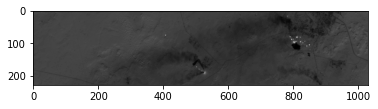

B12 data


array([[0.5267, 0.5248, 0.5307, ..., 0.5742, 0.6257, 0.6238],
       [0.5148, 0.5136, 0.5268, ..., 0.5719, 0.5594, 0.5535],
       [0.5032, 0.515 , 0.5246, ..., 0.6294, 0.5948, 0.5805],
       ...,
       [0.5483, 0.552 , 0.5624, ..., 0.5872, 0.5682, 0.5012],
       [0.562 , 0.5592, 0.5695, ..., 0.5264, 0.5642, 0.5461],
       [0.5713, 0.5823, 0.5546, ..., 0.5092, 0.5046, 0.5568]])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
# Define an image.
img = ee.Image('COPERNICUS/S2/20191120T101321_20191120T101408_T32SKA').select(['B11','B12'])
# Define an area of interest.
aoi = ee.Geometry.Polygon(
  [[[5.884328461018904, 31.640509183144996],
    [6.1, 31.640509183144996],
    [6.1, 31.676497731902995],
    [5.884328461018904, 31.676497731902995]]], None, False)
band_arrs = img.sampleRectangle(region=aoi)


# Get individual band arrays.
band_arr_b11 = band_arrs.get('B11')
band_arr_b12 = band_arrs.get('B12')
# Transfer the arrays from server to client and cast as np array.
np_arr_b11 = np.array(band_arr_b11.getInfo())/10000
np_arr_b12 = np.array(band_arr_b12.getInfo())/10000

print(np_arr_b11.shape)
print(np_arr_b12.shape)

plt.imshow(np_arr_b11, cmap='gray')
plt.show()
print("B12 data")
np_arr_b12.view()


06 OCt 2019: B12 and B11 data

(11, 11)
(11, 11)


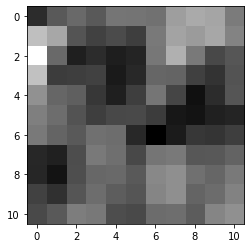

B12 data


array([[0.5326, 0.5392, 0.5414, 0.539 , 0.543 , 0.5428, 0.5426, 0.5488,
        0.5505, 0.5497, 0.5438],
       [0.5534, 0.55  , 0.5383, 0.5357, 0.537 , 0.5352, 0.5437, 0.5495,
        0.5483, 0.5501, 0.5451],
       [0.5626, 0.5413, 0.5307, 0.5326, 0.5306, 0.5315, 0.5433, 0.5513,
        0.5436, 0.5366, 0.5386],
       [0.5537, 0.535 , 0.5351, 0.5358, 0.53  , 0.5322, 0.5409, 0.5406,
        0.5355, 0.5336, 0.5382],
       [0.547 , 0.5409, 0.5398, 0.5341, 0.5308, 0.5352, 0.543 , 0.5362,
        0.5287, 0.5328, 0.5384],
       [0.5444, 0.5418, 0.5382, 0.5351, 0.5366, 0.5367, 0.5349, 0.5297,
        0.529 , 0.5309, 0.5316],
       [0.5435, 0.5405, 0.539 , 0.5423, 0.5418, 0.532 , 0.5263, 0.5302,
        0.5341, 0.5337, 0.5352],
       [0.5319, 0.531 , 0.5373, 0.5436, 0.5421, 0.5366, 0.543 , 0.5436,
        0.5387, 0.5389, 0.5404],
       [0.5317, 0.5291, 0.5374, 0.541 , 0.5413, 0.539 , 0.5457, 0.5467,
        0.5422, 0.5408, 0.5435],
       [0.5358, 0.5333, 0.5384, 0.5418, 0.5395, 0.5384,

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
# Define an image.
img = ee.Image('COPERNICUS/S2/20191006T101029_20191006T101850_T32SKA').select(['B11','B12'])
# Define an area of interest.

aoi = ee.Geometry.Polygon(
  [[[5.904251398470961, 31.657600459220824],
    [5.906351932492321, 31.657600459220824],
    [5.906351932492321, 31.659399886595168],
    [5.904251398470961, 31.659399886595168]]], None, False)
band_arrs = img.sampleRectangle(region=aoi)


# Get individual band arrays.
band_arr_b11 = band_arrs.get('B11')
band_arr_b12 = band_arrs.get('B12')
# Transfer the arrays from server to client and cast as np array.
np_arr_b11_nop = np.array(band_arr_b11.getInfo())/10000
np_arr_b12_nop = np.array(band_arr_b12.getInfo())/10000

print(np_arr_b11_nop.shape)
print(np_arr_b12_nop.shape)

plt.imshow(np_arr_b12_nop, cmap='gray')
plt.show()
print("B12 data")
np_arr_b12_nop.view()

Least square linear regression function: Output- slope with y_intercept set to 0

In [ ]:
def lsReg(dataB12,dataB11):
    R12=np.zeros([1000000])
    R11=np.zeros([1000000])
    for i in range(dataB11.shape[0]-1):
       R12=np.concatenate((R12,dataB12[i,:]))
       R11=np.concatenate((R11,dataB11[i,:]))

    c,y_int=np.polyfit(R12,R11,1)
    print("slope=",c)
    print("y-intercept=",y_int)
    R11_fitted=np.zeros(len(R11))
    for i in range(len(R12)):
        R11_fitted[i]=c*R12[i]+y_int

    plt.scatter(R12, R11, alpha=0.2)
    plt.plot (R12,R11_fitted,'r')
    plt.xlabel('$R_{12}$', fontsize=12)
    plt.ylabel('$R_{11}$ or $R^{\'}_{12}$ ', fontsize=12)
    plt.xlim((0.3, 0.7))
    plt.ylim((0.3, 0.8))
    plt.show()
    return c,y_int


MBSP case: DeltaR plot

slope= 1.1510089543422075
y-intercept= 1.4117786904544982e-05


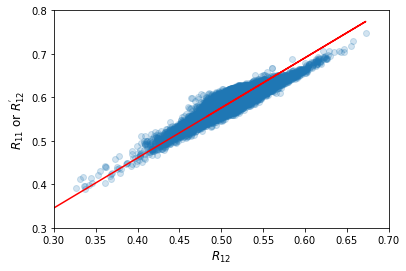

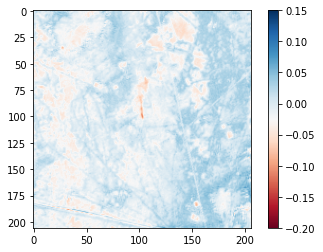

In [ ]:
  c,yint=lsReg(np_arr_b12,np_arr_b11)
  delR=np.divide((c*np_arr_b12-np_arr_b11),np_arr_b11)
  plt.imshow(delR,cmap='RdBu')
  plt.colorbar()
  plt.clim((-0.20,0.15))
  plt.show()


SBMP case: DeltaR plot

slope= 1.0473647457921704
y-intercept= 1.3880970953775315e-05


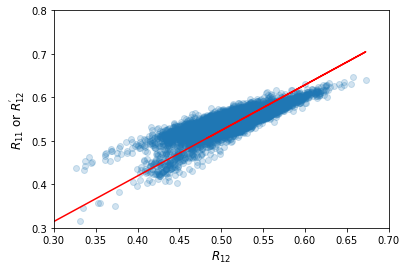

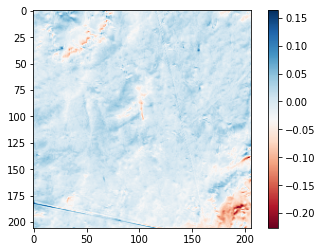

In [ ]:
 c,yint=lsReg(np_arr_b12,np_arr_b12_nop)
 delR=np.divide((c*np_arr_b12-np_arr_b12_nop),np_arr_b12_nop)
 plt.imshow(delR,cmap='RdBu')
 plt.colorbar()
 #plt.clim((-0.1,0))
 plt.show()